## Lab 6 z Podstaw Uczenia Maszynowego - Las Losowy
### Autor: Dominik Pabiniak
### Nr indeksu: 254397

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def sensitivity(m_p):
    return round((m_p[0][0]/(m_p[0][0] + m_p[0][1])), 4)
def specificity(m_p):
    return round((m_p[1][1]/(m_p[1][0] + m_p[1][1])), 4)

def plot_class(X_syn_test, y_syn_test, model, method):
        X_pred_0 = X_syn_test[y_syn_test == 0]
        X_pred_1 = X_syn_test[y_syn_test == 1]
        x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
        y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
        plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
        plt.title(f'Powierzchnia decyzyjna {method}')
        plt.xlabel('Cecha 1')
        plt.ylabel('Cecha 2')
        plt.legend()

def pred_info(y_test, y_pred, name_of_method):
    accuracy = accuracy_score(y_test, y_pred)
    c_matrix = confusion_matrix(y_test, y_pred)
    print(f'\n{name_of_method}:')
    print(f'Macierz pomylek: \n{c_matrix}')
    print(f'Dokladnosc: {accuracy}\nCzulosc: {sensitivity(c_matrix)}\nSwoistosc: {specificity(c_matrix)}')

In [67]:
import random

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class MRandomTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_labels = len(np.unique(y))

        features = int((X.shape[1])**0.5)
        max_features = X.shape[1]
        feature_indices = np.random.choice(max_features, features, replace=False)
        X_sample = X[:, feature_indices]
        

        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._find_best_split(X_sample, y)

        left_indices = X_sample[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        _, n_features = X.shape
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(n_features):
            thresholds = np.linspace(min(X[:, feature_index]), max(X[:, feature_index]), 20)
            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = ~left_indices
                gini = self._gini(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini(self, *sides):
        total_samples = sum(len(side) for side in sides)
        gini = 0.0
        for side in sides:
            size = float(len(side))
            if size == 0:
                continue
            score = 1.0
            for class_val in np.unique(side):
                p = np.sum(side == class_val) / size
                score -= p ** 2
            gini += score * (size / total_samples)
        return gini

    def _most_common_label(self, y):
        y_int = y.astype(np.int64)
        return np.bincount(y_int).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree_) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

class MRandomForest:
    def __init__(self, n_trees=10, max_depth=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = int((X.shape[1])**0.5)
        self.max_features = X.shape[1]
        self.trees = []

        for _ in range(self.n_trees):
            tree = MRandomTree(max_depth=self.max_depth)
            X_sample, y_sample = self._bagging_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bagging_sample(self, X, y):
        n_samples = X.shape[0]
        max_samples = random.randint(2, n_samples)
        indices = np.random.choice(n_samples, max_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        return np.array([self._most_common_label(tree_pred) for tree_pred in tree_preds])

    def _most_common_label(self, y):
        return np.bincount(y).argmax()


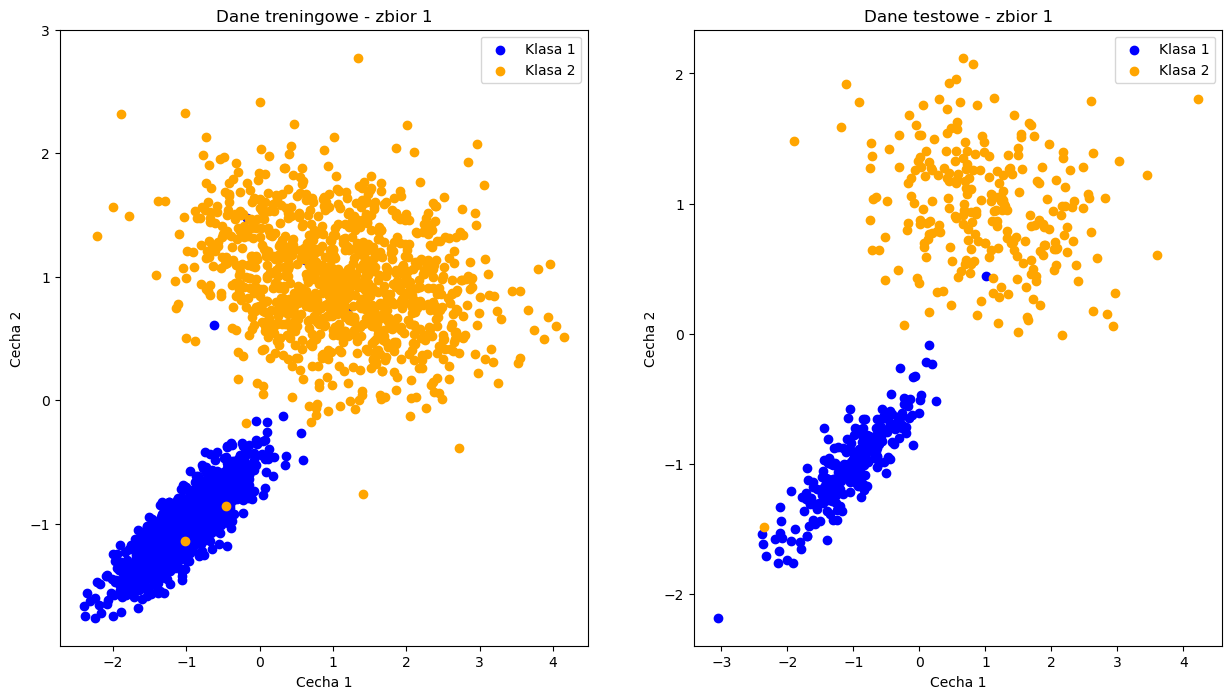

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

index = 254397

scaler = MinMaxScaler()
# Dane wejsciowe
X, t = make_classification(n_samples=2597, n_features=2, n_clusters_per_class=1, n_redundant=0, random_state=index)

#Podzial na podzbiory
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, t, test_size=0.2, random_state=index)


# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train = X_train_2[(y_train_2 == 0)]
klasa_1_train = X_train_2[(y_train_2 == 1)]
klasa_0_test = X_test_2[(y_test_2 == 0)]
klasa_1_test = X_test_2[(y_test_2 == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train[:,0], klasa_0_train[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train[:,0], klasa_1_train[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test[:,0], klasa_0_test[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test[:,0], klasa_1_test[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

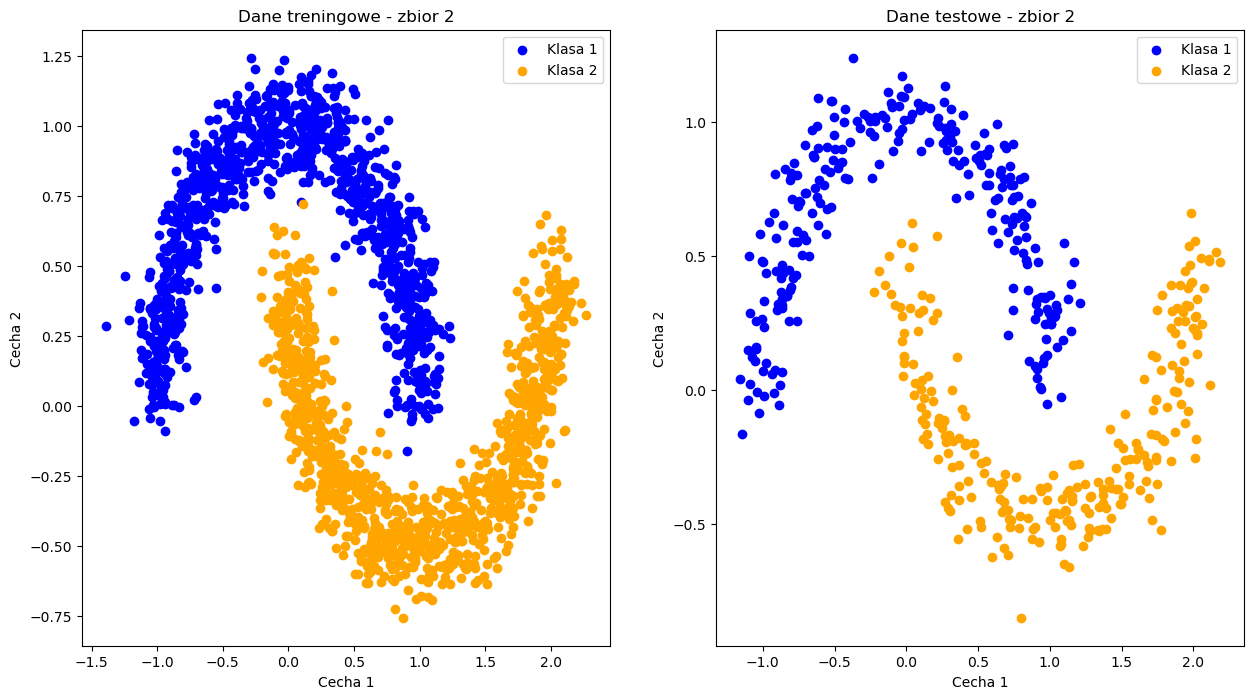

In [6]:
from sklearn.datasets import make_moons

# Dane wejsciowe
X_m, t_m = make_moons(n_samples=2597, random_state=index, noise=0.1)

#Podzial na podzbiory
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X_m, t_m, test_size=0.2, random_state=index)

# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train_M = X_train_M[(y_train_M == 0)]
klasa_1_train_M = X_train_M[(y_train_M == 1)]
klasa_0_test_M = X_test_M[(y_test_M == 0)]
klasa_1_test_M = X_test_M[(y_test_M == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train_M[:,0], klasa_0_train_M[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train_M[:,0], klasa_1_train_M[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 2")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test_M[:,0], klasa_0_test_M[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test_M[:,0], klasa_1_test_M[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 2")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

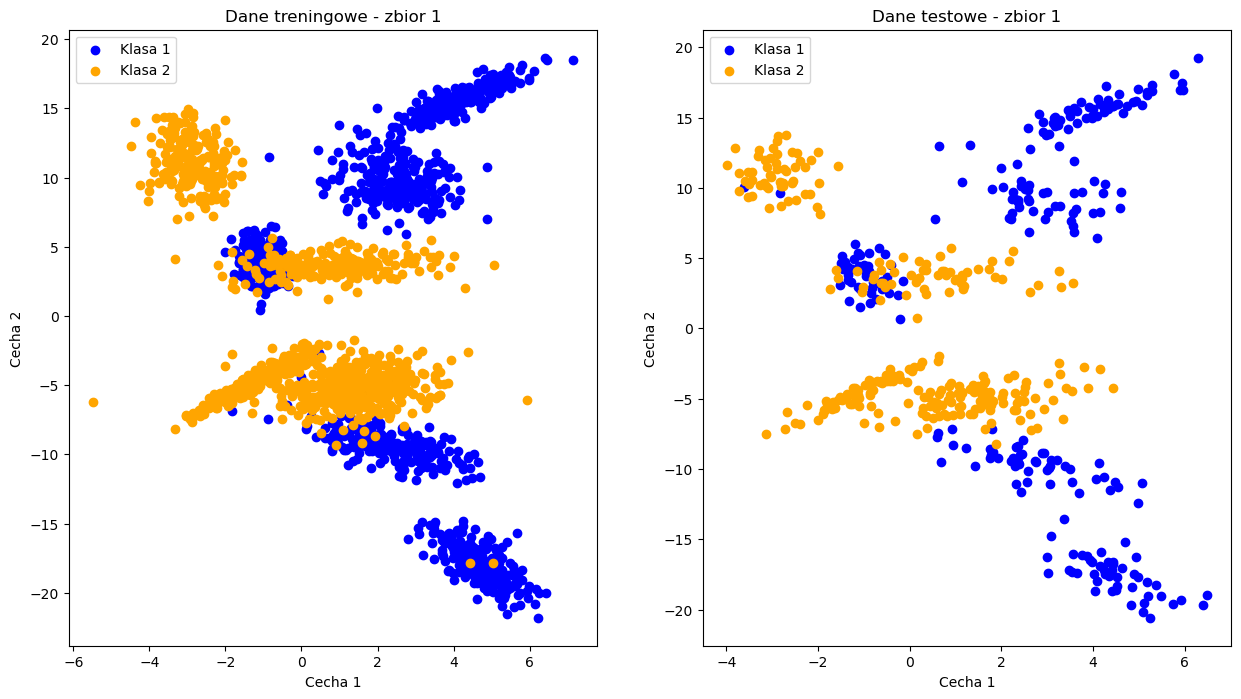

In [7]:
# Dane wejsciowe
X, t = make_classification(n_samples=2597, n_features=4, n_informative=4, n_repeated=0, n_clusters_per_class=5, random_state=index, hypercube=False, n_redundant=0, class_sep=20)
X = X[:,:2]
#Podzial na podzbiory
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, t, test_size=0.2, random_state=index)

# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train = X_train_4[(y_train_4 == 0)]
klasa_1_train = X_train_4[(y_train_4 == 1)]
klasa_0_test = X_test_4[(y_test_4 == 0)]
klasa_1_test = X_test_4[(y_test_4 == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train[:,0], klasa_0_train[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train[:,0], klasa_1_train[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test[:,0], klasa_0_test[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test[:,0], klasa_1_test[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

Skelarn
Sredni czas przy nieograniczonej glebokosci: 0.005003376007080078 s
Sredni czas przy glebokosci = 2: 0.004495069980621338 s

Custom
Sredni czas przy glebokosci = 6: 0.02911862850189209 s
Sredni czas przy glebokosci = 2: 0.018747715950012206 s

Glebokosc=6 (SKlearn):
Macierz pomylek: 
[[261   2]
 [  1 256]]
Dokladnosc: 0.9942307692307693
Czulosc: 0.9924
Swoistosc: 0.9961

Glebokosc=2 (SKlearn):
Macierz pomylek: 
[[261   2]
 [  1 256]]
Dokladnosc: 0.9942307692307693
Czulosc: 0.9924
Swoistosc: 0.9961

Glebokosc=6 (Custom):
Macierz pomylek: 
[[258   5]
 [  2 255]]
Dokladnosc: 0.9865384615384616
Czulosc: 0.981
Swoistosc: 0.9922

Glebokosc=2 (Custom):
Macierz pomylek: 
[[258   5]
 [ 17 240]]
Dokladnosc: 0.9576923076923077
Czulosc: 0.981
Swoistosc: 0.9339


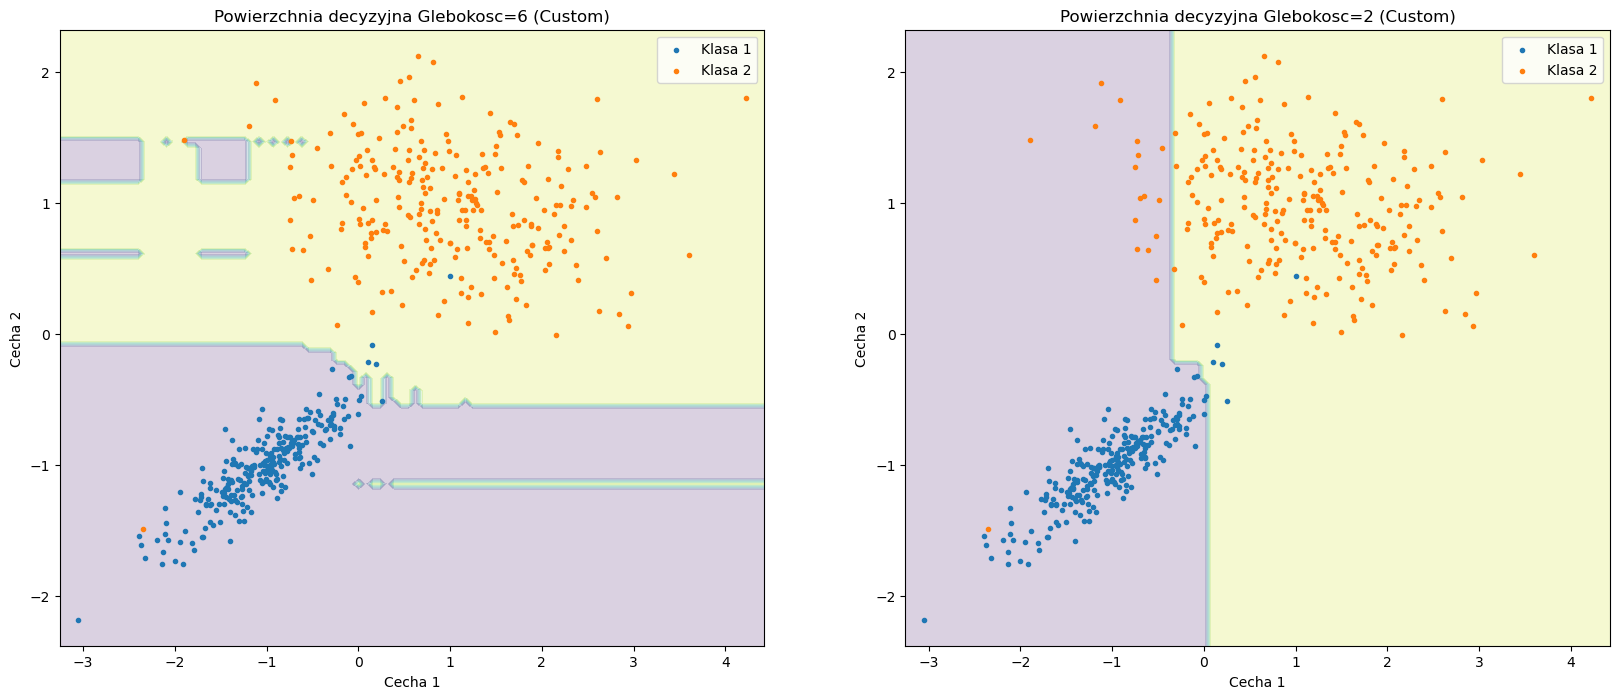

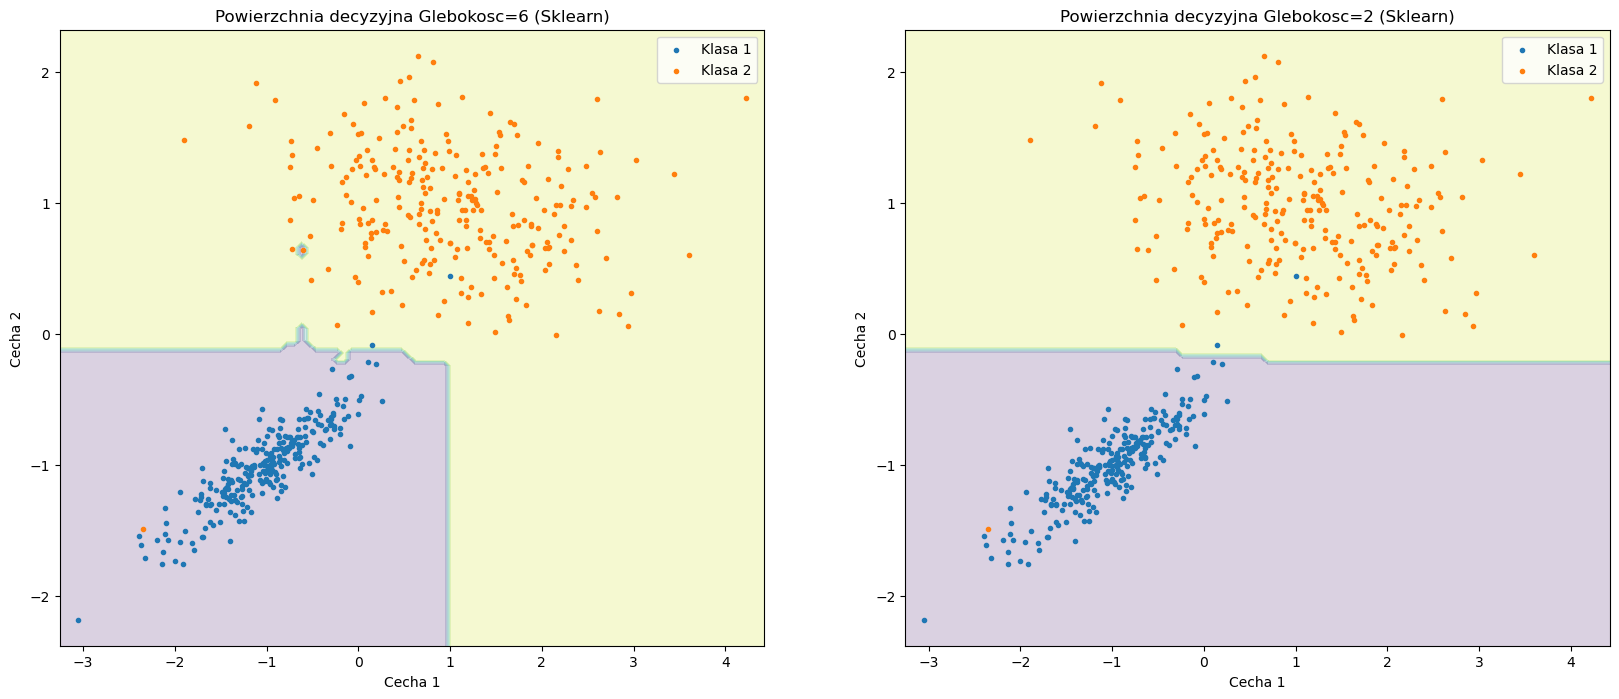

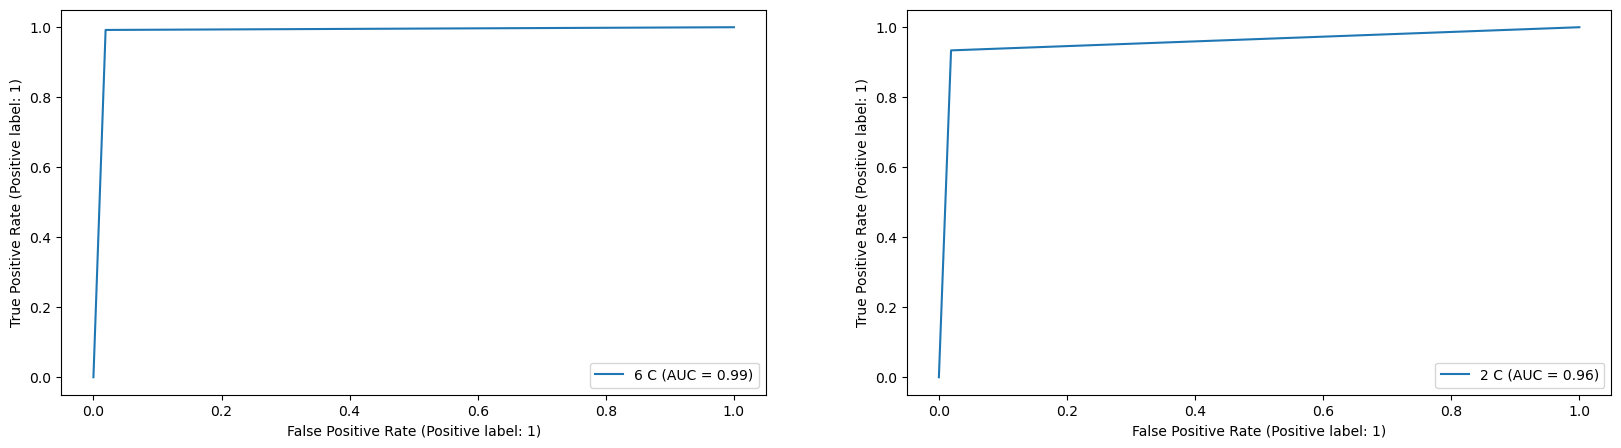

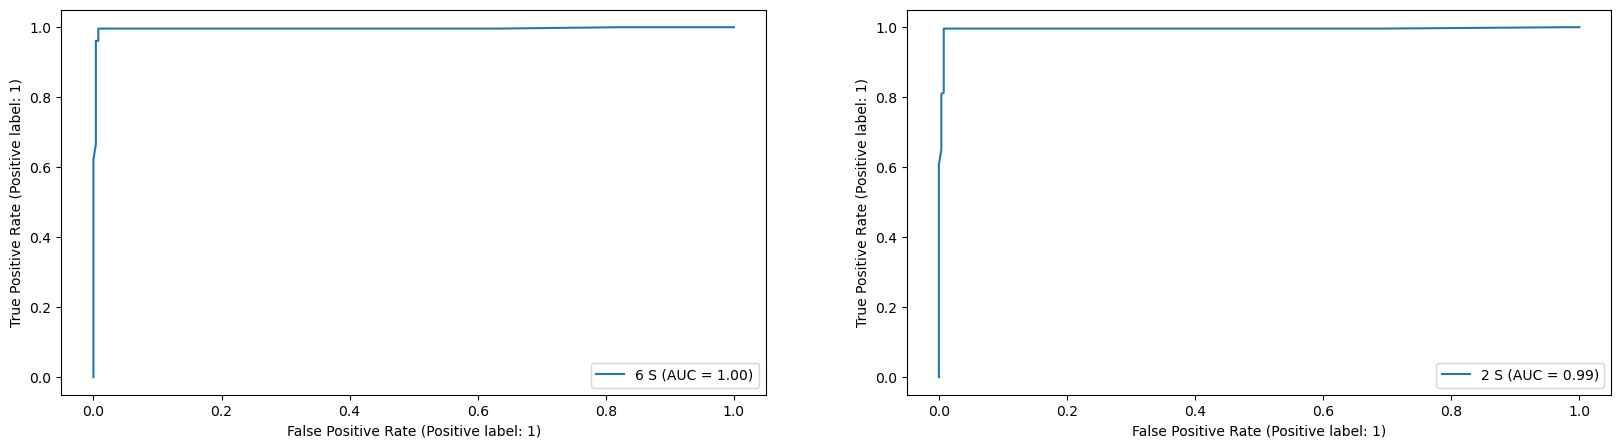

In [68]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

print('Skelarn')
# Nieograniczona glebokosc
dt_s2_n = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=6)
dt_s2_n.fit(X_train_2, y_train_2)
start = time.time()
for i in range(100):
    y_pred_s2_n = dt_s2_n.predict(X_test_2)
end = time.time()
print(f'Sredni czas przy nieograniczonej glebokosci: {(end - start)/100} s')

# Glebokosc rowna ilosci cech
dt_s2_2 = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=2)
dt_s2_2.fit(X_train_2, y_train_2)
start = time.time()
for i in range(100):
    y_pred_s2_2 = dt_s2_2.predict(X_test_2)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')


print('\nCustom')
# Nieograniczona glebokosc
dt_2_n = MRandomForest(max_depth=6, n_trees=100)
dt_2_n.fit(X_train_2, y_train_2)
start = time.time()
for i in range(100):
    y_pred_2_n = dt_2_n.predict(X_test_2)
end = time.time()
print(f'Sredni czas przy glebokosci = 6: {(end - start)/100} s')

# Glebokosc rowna ilosci cech
dt_2_2 = MRandomForest(max_depth=2, n_trees=100)
dt_2_2.fit(X_train_2, y_train_2)
start = time.time()
for i in range(100):
    y_pred_2_2 = dt_2_2.predict(X_test_2)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')


pred_info(y_test_2, y_pred_s2_n, 'Glebokosc=6 (SKlearn)')
pred_info(y_test_2, y_pred_s2_2, 'Glebokosc=2 (SKlearn)')
pred_info(y_test_2, y_pred_2_n, 'Glebokosc=6 (Custom)')
pred_info(y_test_2, y_pred_2_2, 'Glebokosc=2 (Custom)')


plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_2, y_test_2, dt_2_n, 'Glebokosc=6 (Custom)')
plt.subplot(1, 2, 2)
plot_class(X_test_2, y_test_2, dt_2_2, 'Glebokosc=2 (Custom)')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_2, y_test_2, dt_s2_n, 'Glebokosc=6 (Sklearn)')
plt.subplot(1, 2, 2)
plot_class(X_test_2, y_test_2, dt_s2_2, 'Glebokosc=2 (Sklearn)')


_, axs = plt.subplots(1, 2, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_2, y_pred_2_n, name='6 C', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_2, y_pred_2_2, name='2 C', ax=axs[1])
y_scores_s2_n = dt_s2_n.predict_proba(X_test_2)[:, 1]
y_scores_s2_2 = dt_s2_2.predict_proba(X_test_2)[:, 1]

_, axs = plt.subplots(1, 2, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_2, y_scores_s2_n, name='6 S', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_2, y_scores_s2_2, name='2 S', ax=axs[1])

Sklearn
Sredni czas przy glebokosci = 6: 0.005132839679718017 s
Sredni czas przy glebokosci = 2: 0.0044204783439636235 s

Custom
Sredni czas przy glebokosci = 6: 0.03127575159072876 s
Sredni czas przy glebokosci = 2: 0.019006786346435548 s

Glebokosc=6 (Sklearn):
Macierz pomylek: 
[[264   0]
 [  3 253]]
Dokladnosc: 0.9942307692307693
Czulosc: 1.0
Swoistosc: 0.9883

Glebokosc=2 (Sklearn):
Macierz pomylek: 
[[246  18]
 [ 20 236]]
Dokladnosc: 0.926923076923077
Czulosc: 0.9318
Swoistosc: 0.9219

Glebokosc=6 (Custom):
Macierz pomylek: 
[[248  16]
 [ 22 234]]
Dokladnosc: 0.926923076923077
Czulosc: 0.9394
Swoistosc: 0.9141

Glebokosc=2 (Custom):
Macierz pomylek: 
[[234  30]
 [ 16 240]]
Dokladnosc: 0.9115384615384615
Czulosc: 0.8864
Swoistosc: 0.9375


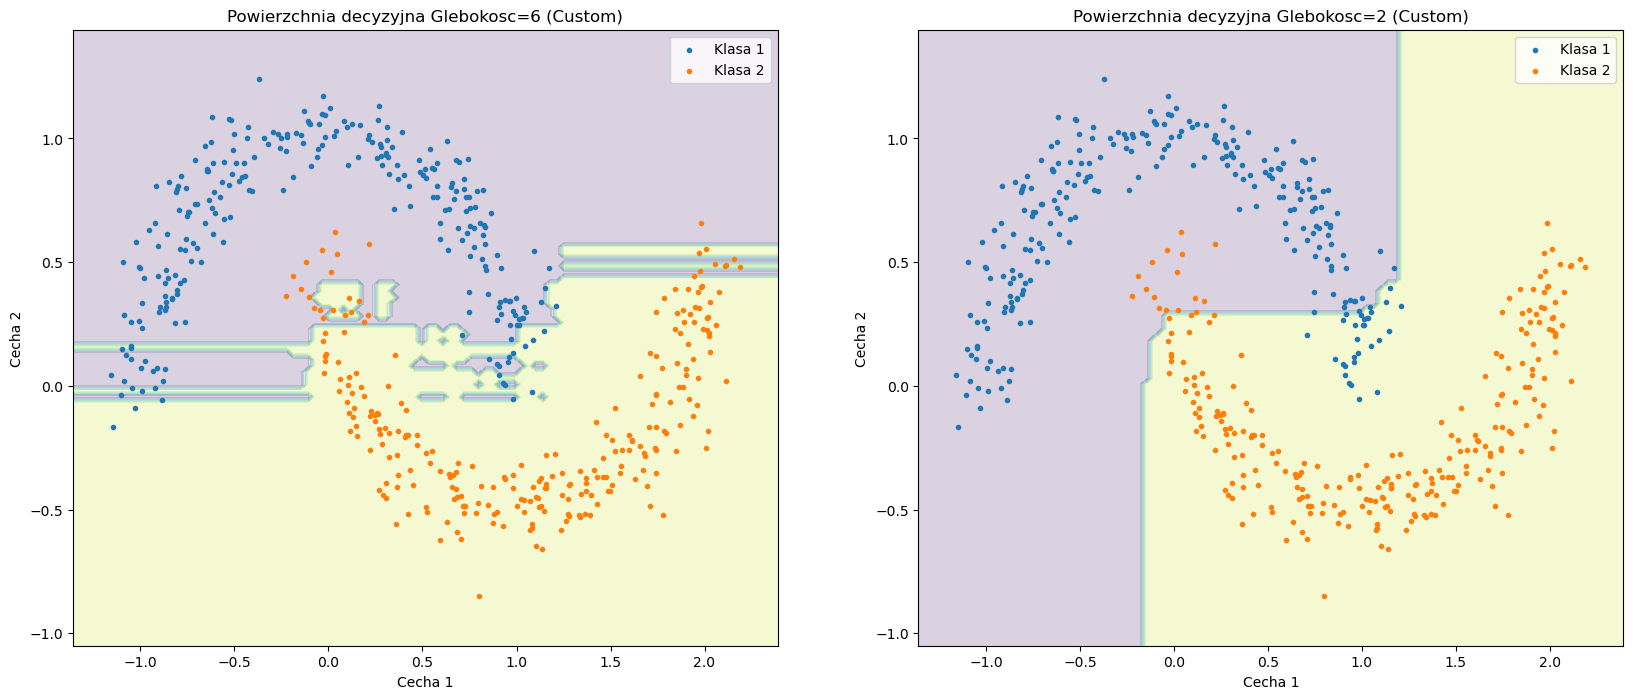

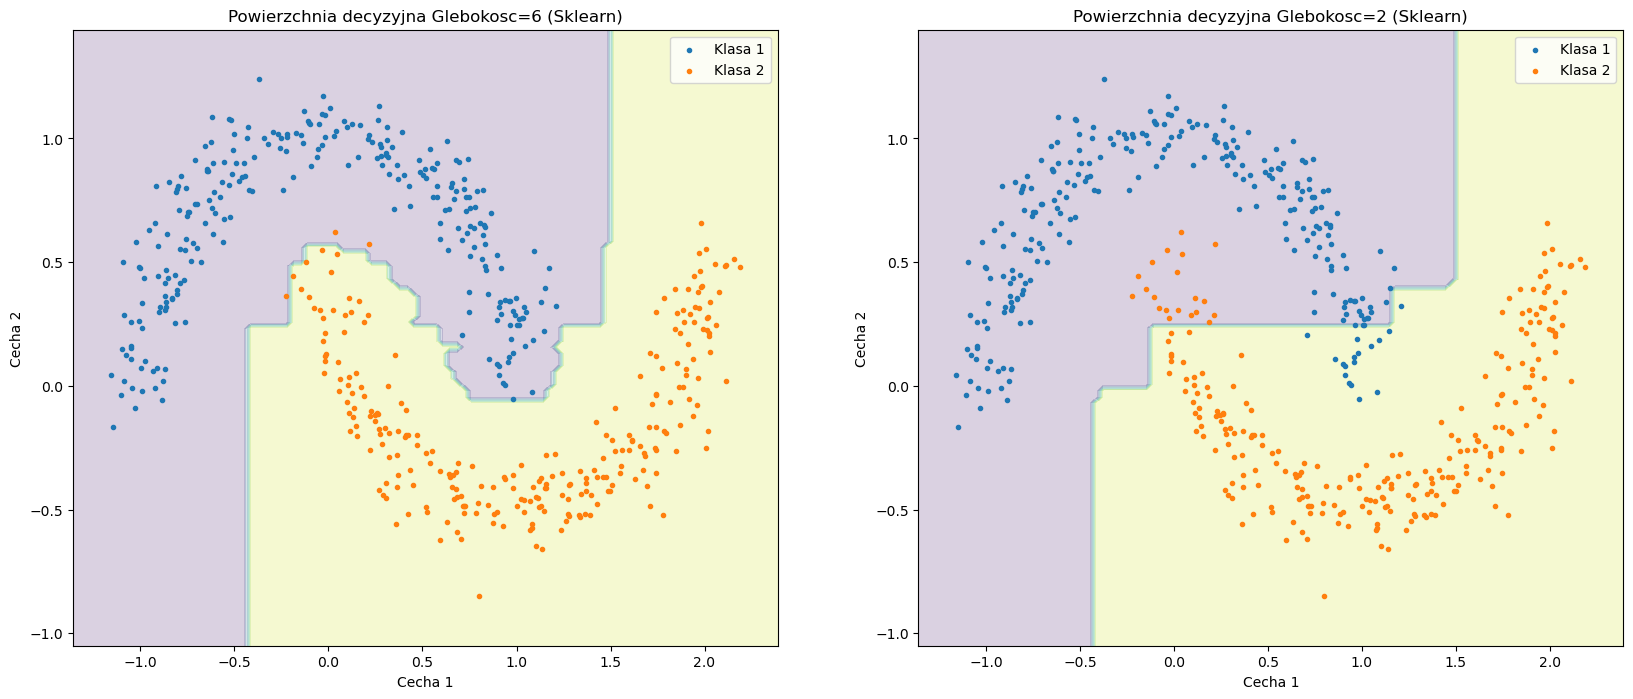

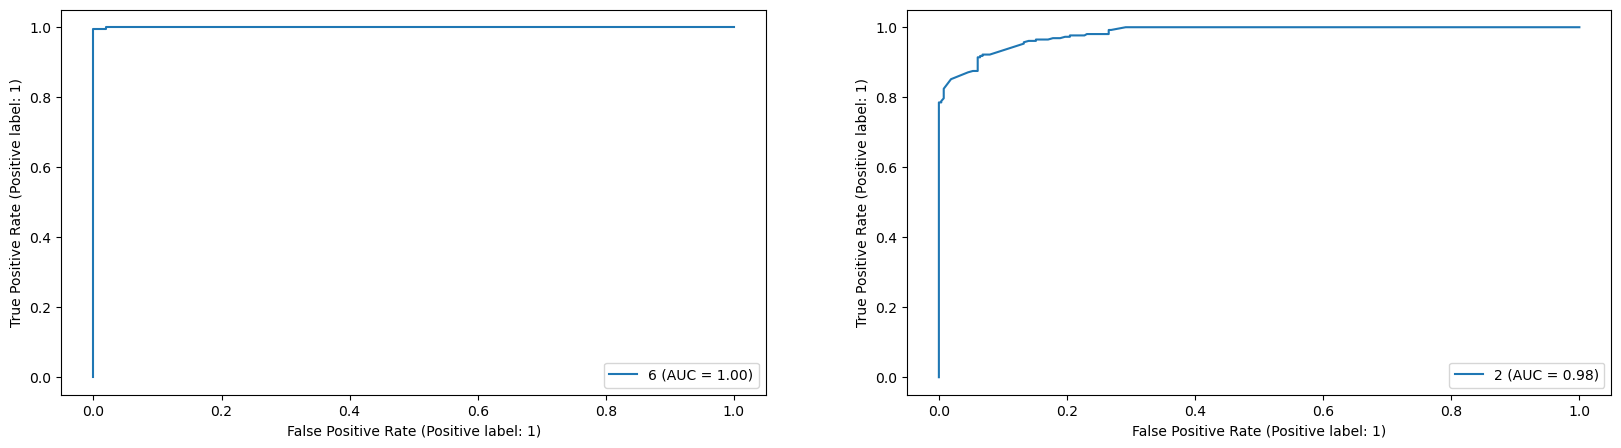

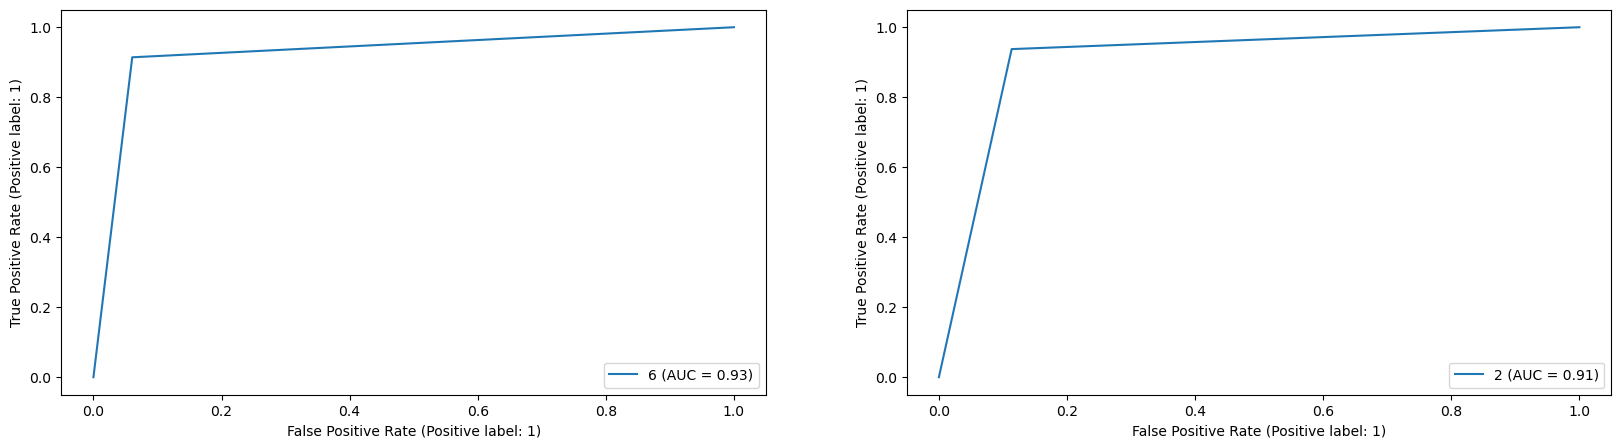

In [72]:
print('Sklearn')
# Nieograniczona glebokosc
dt_m_n = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=6)
dt_m_n.fit(X_train_M, y_train_M)
start = time.time()
for i in range(100):
    y_pred_m_n = dt_m_n.predict(X_test_M)
end = time.time()
print(f'Sredni czas przy glebokosci = 6: {(end - start)/100} s')

# Glebokosc rowna ilosci cech
dt_m_2 = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=2)
dt_m_2.fit(X_train_M, y_train_M)
start = time.time()
for i in range(100):
    y_pred_m_2 = dt_m_2.predict(X_test_M)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')


print('\nCustom')
# Nieograniczona glebokosc
dt_m2m_n = MRandomForest(max_depth=6, n_trees=100)
dt_m2m_n.fit(X_train_M, y_train_M)
start = time.time()
for i in range(100):
    y_pred_m2m_n = dt_m2m_n.predict(X_test_M)
end = time.time()
print(f'Sredni czas przy glebokosci = 6: {(end - start)/100} s')

# Glebokosc rowna ilosci cech
dt_m2m_2 = MRandomForest(max_depth=2, n_trees=100)
dt_m2m_2.fit(X_train_M, y_train_M)
start = time.time()
for i in range(100):
    y_pred_m2m_2 = dt_m2m_2.predict(X_test_M)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')


pred_info(y_test_M, y_pred_m_n, 'Glebokosc=6 (Sklearn)')
pred_info(y_test_M, y_pred_m_2, 'Glebokosc=2 (Sklearn)')
pred_info(y_test_M, y_pred_m2m_n, 'Glebokosc=6 (Custom)')
pred_info(y_test_M, y_pred_m2m_2, 'Glebokosc=2 (Custom)')


plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_M, y_test_M, dt_m2m_n, 'Glebokosc=6 (Custom)')
plt.subplot(1, 2, 2)
plot_class(X_test_M, y_test_M, dt_m2m_2, 'Glebokosc=2 (Custom)')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_M, y_test_M, dt_m_n, 'Glebokosc=6 (Sklearn)')
plt.subplot(1, 2, 2)
plot_class(X_test_M, y_test_M, dt_m_2, 'Glebokosc=2 (Sklearn)')

y_scores_m_n = dt_m_n.predict_proba(X_test_M)[:, 1]
y_scores_m_2 = dt_m_2.predict_proba(X_test_M)[:, 1]

_, axs = plt.subplots(1, 2, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_M, y_scores_m_n, name='6', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_M, y_scores_m_2, name='2', ax=axs[1])

_, axs = plt.subplots(1, 2, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_M, y_pred_m2m_n, name='6', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_M, y_pred_m2m_2, name='2', ax=axs[1])

Sklearn
Sredni czas przy glebokosci = 6: 0.005352203845977783 s
Sredni czas przy glebokosci = 2: 0.00443516731262207 s
Sredni czas przy glebokosci = 10: 0.005720894336700439 s

Custom
Sredni czas przy glebokosci = 6: 0.03555158615112305 s
Sredni czas przy glebokosci = 2: 0.019076409339904784 s
Sredni czas przy glebokosci = 10: 0.04464099645614624 s

Glebokosc=6 (Sklearn):
Macierz pomylek: 
[[239   8]
 [ 18 255]]
Dokladnosc: 0.95
Czulosc: 0.9676
Swoistosc: 0.9341

Glebokosc=2 (Sklearn):
Macierz pomylek: 
[[190  57]
 [ 20 253]]
Dokladnosc: 0.8519230769230769
Czulosc: 0.7692
Swoistosc: 0.9267

Glebokosc=10 (Sklearn):
Macierz pomylek: 
[[239   8]
 [ 18 255]]
Dokladnosc: 0.95
Czulosc: 0.9676
Swoistosc: 0.9341

Glebokosc=6 (Custom):
Macierz pomylek: 
[[224  23]
 [ 30 243]]
Dokladnosc: 0.8980769230769231
Czulosc: 0.9069
Swoistosc: 0.8901

Glebokosc=2 (Custom):
Macierz pomylek: 
[[185  62]
 [ 25 248]]
Dokladnosc: 0.8326923076923077
Czulosc: 0.749
Swoistosc: 0.9084

Glebokosc=10 (Custom):
Macie

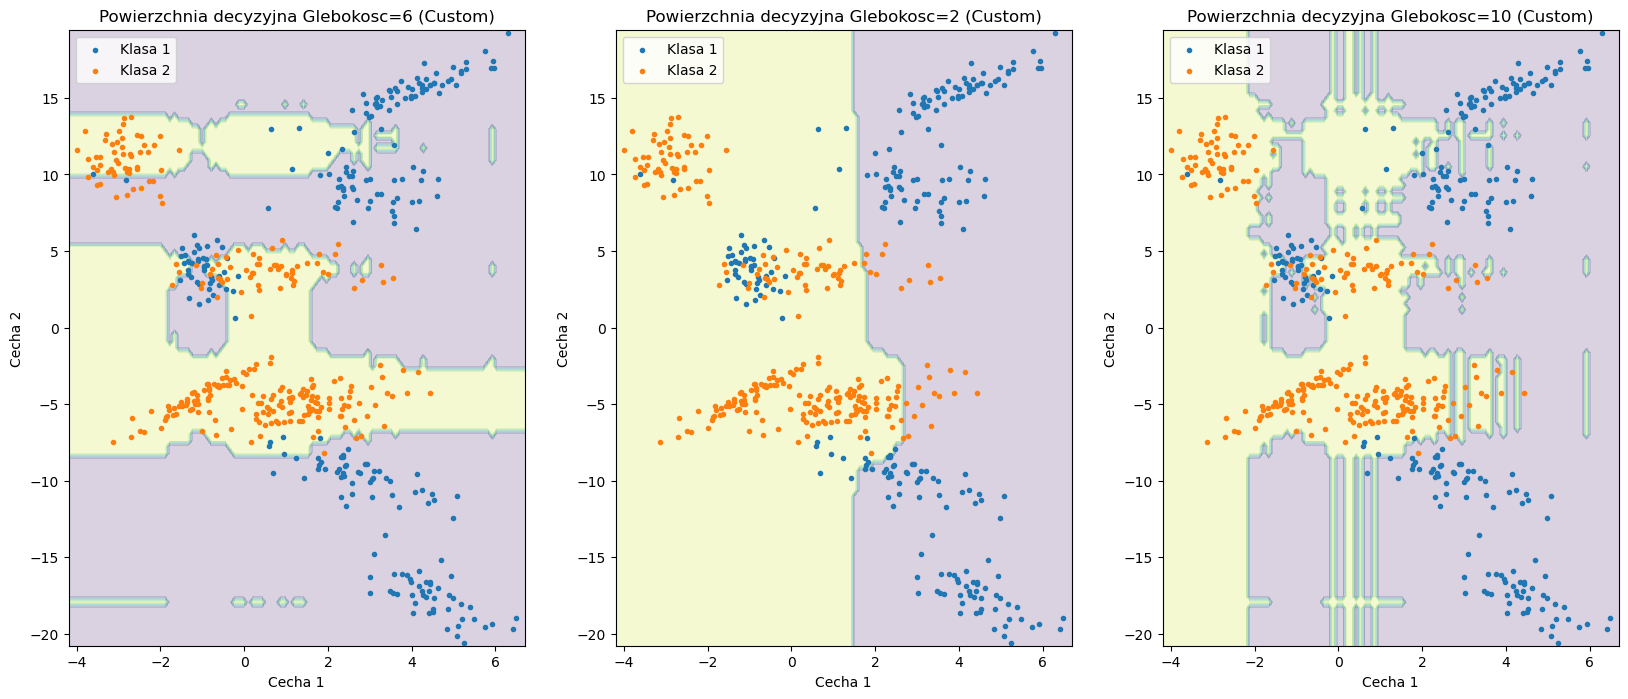

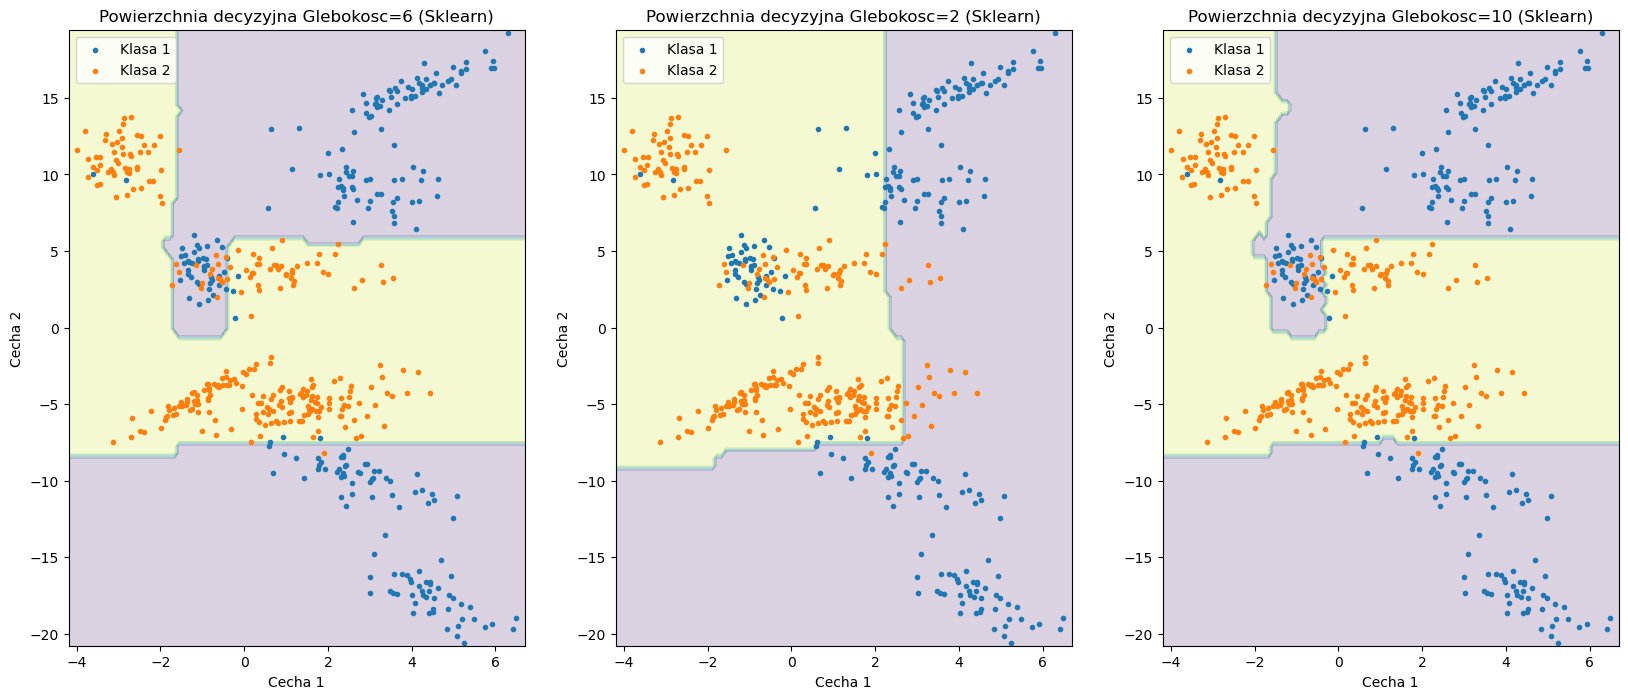

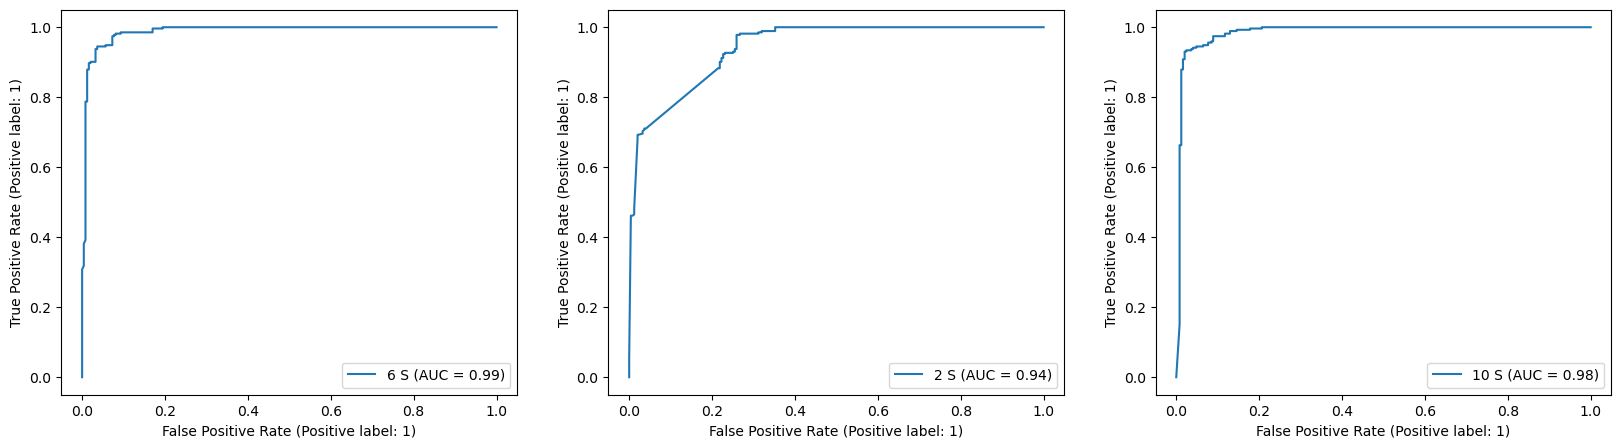

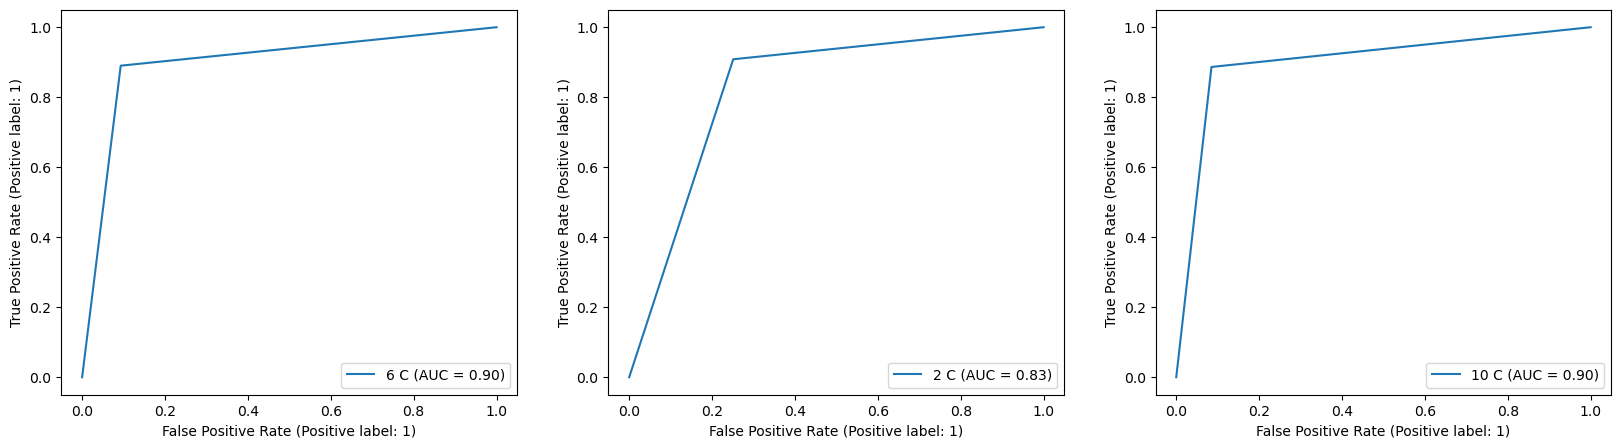

In [71]:
# Nieograniczona glebokosc
print('Sklearn')
dt_4_n = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=6)
dt_4_n.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_4_n = dt_4_n.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 6: {(end - start)/100} s')


# Glebokosc rowna ilosci cech
dt_4_4 = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=2)
dt_4_4.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_4_4 = dt_4_4.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')

# Glebokosc rowna ilosci klastrow
dt_4_5 = RandomForestClassifier(random_state=index, n_estimators=100, max_depth=10)
dt_4_5.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_4_5 = dt_4_5.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 10: {(end - start)/100} s')


print('\nCustom')
# Nieograniczona glebokosc
dt_m4_n = MRandomForest(max_depth=6, n_trees=100)
dt_m4_n.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_m4_n = dt_m4_n.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 6: {(end - start)/100} s')

# Glebokosc rowna ilosci cech
dt_m4_4 = MRandomForest(max_depth=2, n_trees=100)
dt_m4_4.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_m4_4 = dt_m4_4.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 2: {(end - start)/100} s')

# Glebokosc rowna ilosci klastrow
dt_m4_5 = MRandomForest(max_depth=10, n_trees=100)
dt_m4_5.fit(X_train_4, y_train_4)
start = time.time()
for i in range(100):
    y_pred_m4_5 = dt_m4_5.predict(X_test_4)
end = time.time()
print(f'Sredni czas przy glebokosci = 10: {(end - start)/100} s')

pred_info(y_test_4, y_pred_4_n, 'Glebokosc=6 (Sklearn)')
pred_info(y_test_4, y_pred_4_4, 'Glebokosc=2 (Sklearn)')
pred_info(y_test_4, y_pred_4_5, 'Glebokosc=10 (Sklearn)')

pred_info(y_test_4, y_pred_m4_n, 'Glebokosc=6 (Custom)')
pred_info(y_test_4, y_pred_m4_4, 'Glebokosc=2 (Custom)')
pred_info(y_test_4, y_pred_m4_5, 'Glebokosc=10 (Custom)')

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plot_class(X_test_4, y_test_4, dt_m4_n, 'Glebokosc=6 (Custom)')
plt.subplot(1, 3, 2)
plot_class(X_test_4, y_test_4, dt_m4_4, 'Glebokosc=2 (Custom)')
plt.subplot(1, 3, 3)
plot_class(X_test_4, y_test_4, dt_m4_5, 'Glebokosc=10 (Custom)')

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plot_class(X_test_4, y_test_4, dt_4_n, 'Glebokosc=6 (Sklearn)')
plt.subplot(1, 3, 2)
plot_class(X_test_4, y_test_4, dt_4_4, 'Glebokosc=2 (Sklearn)')
plt.subplot(1, 3, 3)
plot_class(X_test_4, y_test_4, dt_4_5, 'Glebokosc=10 (Sklearn)')

y_scores_4_n = dt_4_n.predict_proba(X_test_4)[:, 1]
y_scores_4_4 = dt_4_4.predict_proba(X_test_4)[:, 1]
y_scores_4_5 = dt_4_5.predict_proba(X_test_4)[:, 1]

_, axs = plt.subplots(1, 3, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_4, y_scores_4_n, name='6 S', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_4, y_scores_4_4, name='2 S', ax=axs[1])
RocCurveDisplay.from_predictions(y_test_4, y_scores_4_5, name='10 S', ax=axs[2])


_, axs = plt.subplots(1, 3, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_4, y_pred_m4_n, name='6 C', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_4, y_pred_m4_4, name='2 C', ax=axs[1])
RocCurveDisplay.from_predictions(y_test_4, y_pred_m4_5, name='10 C', ax=axs[2])

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

nasa_data = pd.read_csv('NASA_JPL_asteroid.csv', low_memory=False)

# Usuwanie zbednych kolumn
nasa_data.drop(columns=['id', 'spkid', 'full_name', 'pdes', 'orbit_id', 'equinox'], inplace=True)
# Usuwanie kolumn >30% missing
missing_percentage = nasa_data.isna().mean()
columns_to_drop = missing_percentage[missing_percentage > 0.3].index
nasa_data = nasa_data.drop(columns=columns_to_drop)

# Zamiana neo oraz pha na 1/0
columns_to_encode = ['neo', 'pha']
nasa_data[columns_to_encode] = nasa_data[columns_to_encode].replace({'N': 0, 'Y': 1})

# Imputacja MCAR oraz normalizacja OneHotEncoder dla kategorycznych
numeric_columns = nasa_data.select_dtypes(include=['number']).columns
for col in numeric_columns:
    median_value = nasa_data[col].median()
    nasa_data[col].fillna(median_value, inplace=True)
# print(nasa_data['class'].unique())
encoded_df = pd.get_dummies(nasa_data['class'])
nasa_data = pd.concat([nasa_data, encoded_df], axis = 1)
nasa_data = nasa_data.drop(columns=['class'])
nasa_data

,neo,pha,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,...,ATE,CEN,HYA,IEO,IMB,MBA,MCA,OMB,TJN,TNO
0,0.0,0.0,3.400,2458600.5,58600,20190427.0,0.076009,2.769165,2.558684,10.594067,...,False,False,False,False,False,True,False,False,False,False
1,0.0,0.0,4.200,2459000.5,59000,20200531.0,0.229972,2.773841,2.135935,34.832932,...,False,False,False,False,False,True,False,False,False,False
2,0.0,0.0,5.330,2459000.5,59000,20200531.0,0.256936,2.668285,1.982706,12.991043,...,False,False,False,False,False,True,False,False,False,False
3,0.0,0.0,3.000,2458600.5,58600,20190427.0,0.088721,2.361418,2.151909,7.141771,...,False,False,False,False,False,True,False,False,False,False
4,0.0,0.0,6.900,2459000.5,59000,20200531.0,0.190913,2.574037,2.082619,5.367427,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958519,0.0,0.0,17.135,2437203.5,37203,19600926.0,0.185919,2.280861,1.856807,5.984416,...,False,False,False,False,False,True,False,False,False,False
958520,0.0,0.0,18.500,2459000.5,59000,20200531.0,0.282920,2.334910,1.674319,8.082280,...,False,False,False,False,False,True,False,False,False,False
958521,1.0,1.0,20.400,2459000.5,59000,20200531.0,0.662446,2.817152,0.950941,4.679278,...,False,False,False,False,False,False,False,False,False,False
958522,0.0,0.0,18.071,2441956.5,41956,19731001.0,0.202053,2.373137,1.893638,0.732484,...,False,False,False,False,False,True,False,False,False,False


In [11]:
from sklearn.model_selection import train_test_split
X_neo = np.array(nasa_data.drop(columns='neo', inplace=False))
t_neo = np.array(nasa_data['neo'])

X_neo_train, X_neo_test, y_neo_train, y_neo_test = train_test_split(X_neo, t_neo, test_size=0.25, stratify=t_neo, random_state=index)

In [16]:
from sklearn.model_selection import GridSearchCV

nasa_rf = RandomForestClassifier(random_state=index)

param_grid = {
    'n_estimators': [10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8]
}

grid_search = GridSearchCV(nasa_rf, param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=1)

start = time.time()
grid_search.fit(X_neo_train, y_neo_train)
end = time.time()
print(f'Czas Grid Search: {(end - start)/60} min')

best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Czas Grid Search: 20.7676060517629 min
Najlepsze parametry: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Sredni czas: 0.8475456762313843 s

Najlepsze parametry:
Macierz pomylek: 
[[233907      0]
 [     0   5724]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0


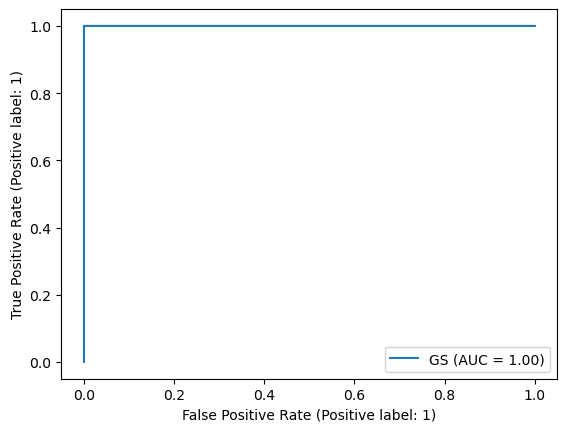

In [17]:
best_estimator = grid_search.best_estimator_
start = time.time()
for i in range(100):
    y_neo_pred = best_estimator.predict(X_neo_test)
end = time.time()
print(f'Sredni czas: {(end - start)/100} s')

pred_info(y_neo_test, y_neo_pred, 'Najlepsze parametry')
y_neo_scores = best_estimator.predict_proba(X_neo_test)[:, 1]
RocCurveDisplay.from_predictions(y_neo_test, y_neo_scores, name='GS')

In [18]:
X_pha = np.array(nasa_data.drop(columns='pha', inplace=False))
t_pha = np.array(nasa_data['pha'])

X_pha_train, X_pha_test, y_pha_train, y_pha_test = train_test_split(X_pha, t_pha, test_size=0.25, stratify=t_pha, random_state=index)

In [19]:
param_grid = {
    'n_estimators': [10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8]
}

grid_search = GridSearchCV(nasa_rf, param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=1)

start = time.time()
grid_search.fit(X_pha_train, y_pha_train)
end = time.time()
print(f'Czas Grid Search: {(end - start)/60} min')

best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Czas Grid Search: 16.614566882451374 min
Najlepsze parametry: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


Sredni czas: 0.5106655883789063 s

Najlepsze parametry:
Macierz pomylek: 
[[239044     70]
 [   119    398]]
Dokladnosc: 0.9992112873543072
Czulosc: 0.9997
Swoistosc: 0.7698


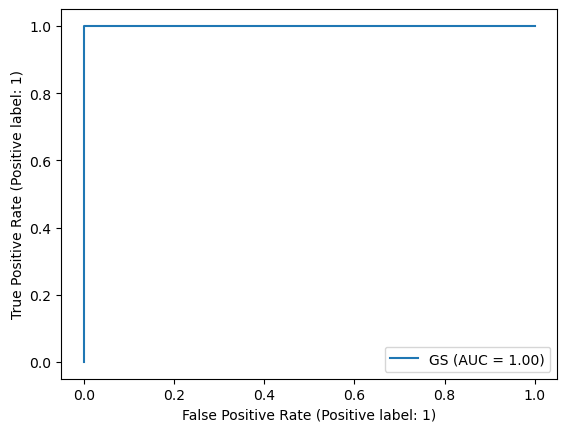

In [20]:
best_estimator = grid_search.best_estimator_
start = time.time()
for i in range(100):
    y_pha_pred = best_estimator.predict(X_pha_test)
end = time.time()
print(f'Sredni czas: {(end - start)/100} s')

pred_info(y_pha_test, y_pha_pred, 'Najlepsze parametry')
y_pha_scores = best_estimator.predict_proba(X_pha_test)[:, 1]
RocCurveDisplay.from_predictions(y_pha_test, y_pha_scores, name='GS')

In [73]:
n_est = range(1, 22, 5)
iterations = 5

scikit_times = []
custom_times = []
scikit_acc = []
custom_acc = []

for j, n_e in enumerate(n_est):
    MDT = MRandomForest(n_trees=n_e, max_depth=10)
    SDT = RandomForestClassifier(n_estimators=n_e, max_depth=10)
    mtimes = []
    macc = []
    stimes = []
    sacc = []
    SDT.fit(X_neo_train, y_neo_train)
    MDT.fit(X_neo_train, y_neo_train)
    print('After fit')
    for _ in range(iterations): 
        start = time.time()
        for _ in range(100):
            mpred = MDT.predict(X_neo_test)
        end = time.time()
        times = (end-start)/100
        accuracy = accuracy_score(y_neo_test, mpred)
        macc.append(accuracy)
        mtimes.append(times)

        start = time.time()
        for _ in range(100):
            spred = SDT.predict(X_neo_test)
        end = time.time()
        times = (end-start)/100
        accuracy = accuracy_score(y_neo_test, spred)
        sacc.append(accuracy)
        stimes.append(times)
    scikit_times.append(np.mean(stimes))
    custom_times.append(np.mean(mtimes))
    scikit_acc.append(np.mean(sacc))
    custom_acc.append(np.mean(macc))
    print(f'N_est {n_e}:\nScikit:\nTime: {scikit_times[j]}, accuracy: {scikit_acc[j]}\nCustom:\nTime: {custom_times[j]}, accuracy: {custom_acc[j]}\n')

After fit
N_est 1:
Scikit:
Time: 0.4049132814407348, accuracy: 0.9998372497715238
Custom:
Time: 0.4632615904808045, accuracy: 0.975929658516636

After fit
N_est 6:
Scikit:
Time: 0.45473163700103764, accuracy: 1.0
Custom:
Time: 1.8549109859466555, accuracy: 0.9977757468774907

After fit
N_est 11:
Scikit:
Time: 0.5082957162857056, accuracy: 1.0
Custom:
Time: 2.9986787805557253, accuracy: 0.9945499538874353

After fit
N_est 16:
Scikit:
Time: 0.5468978757858277, accuracy: 1.0
Custom:
Time: 4.424710352897644, accuracy: 0.9976964583046433

After fit
N_est 21:
Scikit:
Time: 0.5886894197463989, accuracy: 1.0
Custom:
Time: 4.917635667324066, accuracy: 0.9978967662781526



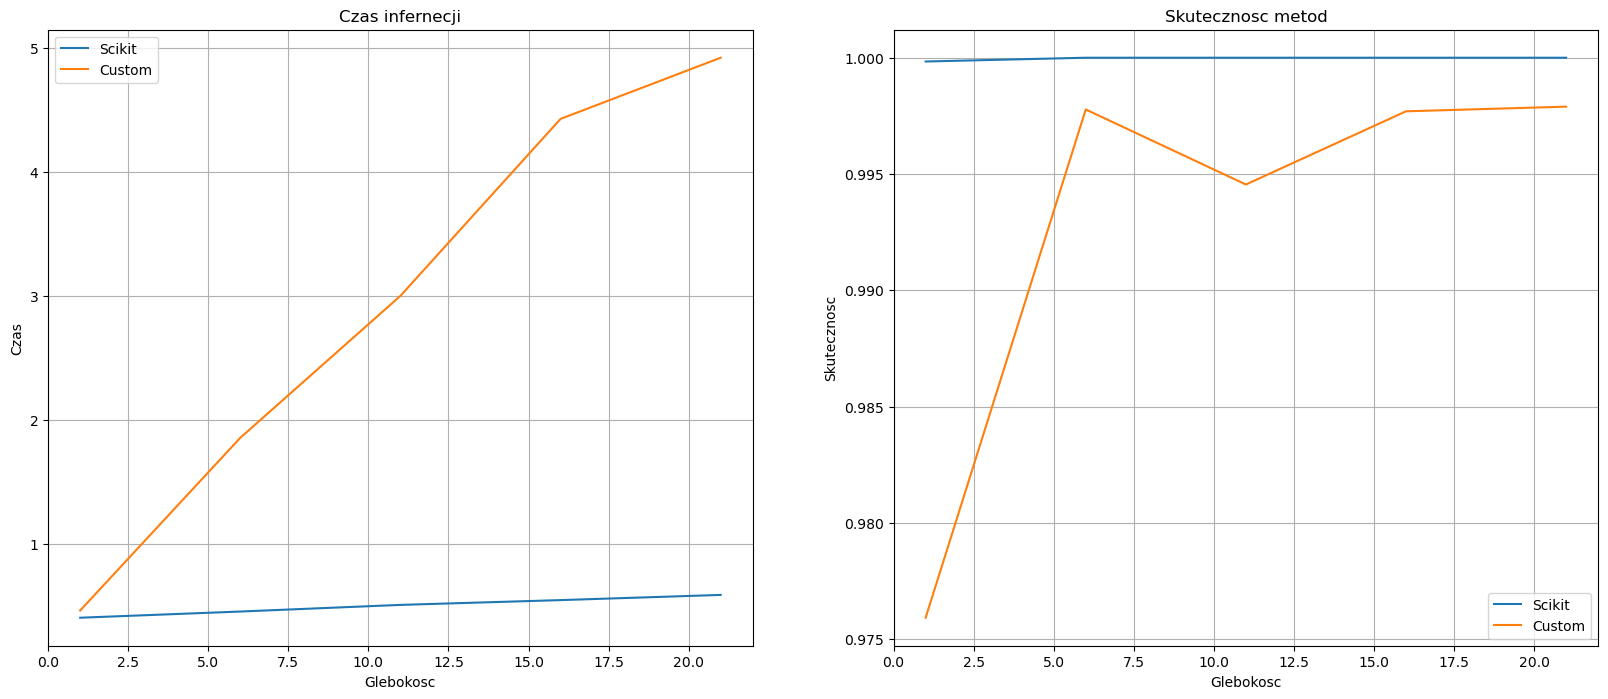

In [74]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))
ax=axs[0]
ax.plot(n_est, scikit_times, label='Scikit')
ax.plot(n_est, custom_times, label='Custom')
ax.set_title('Czas infernecji')
ax.set_xlabel('Glebokosc')
ax.set_ylabel('Czas')
ax.grid()
ax.legend()

ax=axs[1]
ax.plot(n_est, scikit_acc, label='Scikit')
ax.plot(n_est, custom_acc, label='Custom')
ax.set_title('Skutecznosc metod')
ax.set_xlabel('Glebokosc')
ax.set_ylabel('Skutecznosc')
ax.grid()
ax.legend()